In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from truffletopia import Truffle, UnitOperation

# Create Data

In [2]:
np.random.seed(42)

# read the operations data (describes distributions used to synthesize rates)
df = pd.read_csv('../truffletopia/data/operations.csv')
display(df.head())

# create feed costs
df['Cost (USD/KG)'] = np.random.random(size=101)
display(df.head())

# read in truffle_rate data
oee = pd.read_csv("https://raw.githubusercontent.com/wesleybeckner/"\
                 "technology_fundamentals/main/assets/truffle_rates.csv")

# drop values less than 0
oee = oee.loc[oee['rate'] > 0]
oee.reset_index(drop=True, inplace=True)

# change rate to have units
oee.columns = ['base_cake', 'truffle_type', 'primary_flavor', 'secondary_flavor',
       'color_group', 'rate_kg_per_hr']

# use the product descriptors base_cake, truffle_type, and color_group
# to influence the cost of the product. pd.merge to merge on the matching
# values for each descriptor. add some noise so that the costs are not all
# the same
oee['cost_usd_per_kg'] =\
pd.merge(df, oee, left_on='Classification', right_on='base_cake')['Cost (USD/KG)'] +\
pd.merge(df, oee, left_on='Classification', right_on='truffle_type')['Cost (USD/KG)'] +\
pd.merge(df, oee, left_on='Classification', right_on='color_group')['Cost (USD/KG)'] * np.random.random(size=oee.shape[0])

# create a product name column
x = oee['base_cake'].str[:3]
for col in oee.columns[1:-2]:
    x += oee[col].str[:3]
oee['product'] = x

# the price is set for each unique product
price = np.random.random(size=len(x.unique())) + 1.5
price = pd.Series(price, index=x.unique(), name='price_usd_per_kg')

# merge the prices with the original oee df
oee = pd.merge(oee, price, left_on='product', right_on=price.index)

oee = oee[['product', 'base_cake', 'truffle_type', 'primary_flavor', 'secondary_flavor',
       'color_group', 'rate_kg_per_hr', 'cost_usd_per_kg', 
       'price_usd_per_kg']]

# ebit is price - cost
oee['ebit_per_kg'] = oee['price_usd_per_kg'] - oee['cost_usd_per_kg']

# ebit/hr is ebit/kg * kg/hr
oee['ebit_per_hr'] = oee['ebit_per_kg'] * oee['rate_kg_per_hr']

# sort by base_cake for dashboard viewing purpoes
col = 'base_cake'
oee = oee.sort_values([col, 'ebit_per_hr'], ascending=False).reset_index(drop=True)

# add kg produced
oee['kg_produced'] = np.abs(np.random.normal(loc=1000, scale=500) * oee['ebit_per_kg'])

display(oee.head())
oee.to_csv('oee.csv', index=False)

# sample 1000 pts
oee_sample = oee.sample(n=1000)

# and remove columns not necessary for dashboard
oee_sample = oee[['base_cake', 'truffle_type', 'primary_flavor', 'secondary_flavor', 'color_group', 'ebit_per_hr']]
oee_sample.to_csv('oee_1000.csv', index=False)

display(oee_sample.head())

Category Classification   Mean    Std Distribution
0  base_cake       Tiramisu  0.230  2.564       normal
1  base_cake         Sponge  0.794  1.064       normal
2  base_cake          Pound  0.141  1.526       normal
3  base_cake        Chiffon  0.047  1.459       normal
4  base_cake         Cheese  0.361  1.483       normal

Category Classification   Mean    Std Distribution  Cost (USD/KG)
0  base_cake       Tiramisu  0.230  2.564       normal       0.374540
1  base_cake         Sponge  0.794  1.064       normal       0.950714
2  base_cake          Pound  0.141  1.526       normal       0.731994
3  base_cake        Chiffon  0.047  1.459       normal       0.598658
4  base_cake         Cheese  0.361  1.483       normal       0.156019

product base_cake     truffle_type primary_flavor secondary_flavor  \
0  TirChoDilTutOpa  Tiramisu  Chocolate Outer    Dill Pickle     Tutti Frutti   
1  TirChoButRocTif  Tiramisu  Chocolate Outer  Butter Toffee     Rock and Rye   
2  TirJelDilTofSla  Tiramisu     Jelly Filled    Dill Pickle           Toffee   
3  TirChoVanLemRos  Tiramisu  Chocolate Outer        Vanilla            Lemon   
4  TirChoVanLemRos  Tiramisu  Chocolate Outer        Vanilla            Lemon   

  color_group  rate_kg_per_hr  cost_usd_per_kg  price_usd_per_kg  ebit_per_kg  \
0        Opal        1.623284         0.453484          2.116224     1.662740   
1     Tiffany        1.655436         0.762898          1.875938     1.113041   
2       Slate        1.020938         0.895981          2.384675     1.488694   
3        Rose        1.188070         0.758366          2.034873     1.276507   
4        Rose        1.195083         0.768841          2.034873     1.266031   

   ebit_per_hr  kg_produced  
0     2.699099  2628.798422  
1     1.842568  1759.721661  
2     1.519864  2353.631214  
3     1.516580  2018.162777  
4     1.513013  2001.600674

base_cake     truffle_type primary_flavor secondary_flavor color_group  \
0  Tiramisu  Chocolate Outer    Dill Pickle     Tutti Frutti        Opal   
1  Tiramisu  Chocolate Outer  Butter Toffee     Rock and Rye     Tiffany   
2  Tiramisu     Jelly Filled    Dill Pickle           Toffee       Slate   
3  Tiramisu  Chocolate Outer        Vanilla            Lemon        Rose   
4  Tiramisu  Chocolate Outer        Vanilla            Lemon        Rose   

   ebit_per_hr  
0     2.699099  
1     1.842568  
2     1.519864  
3     1.516580  
4     1.513013

# Dashboard Components

In [3]:
# our standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from ipywidgets import interact

# our stats libraries
import random
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy

# our scikit-Learn library for the regression models
import sklearn         
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# our dash libraries
import plotly.express as px
from jupyter_dash import JupyterDash
from dash import dcc, html, callback_context, Dash
import dash_daq as daq
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle

In [4]:
oee = pd.read_csv('oee.csv')

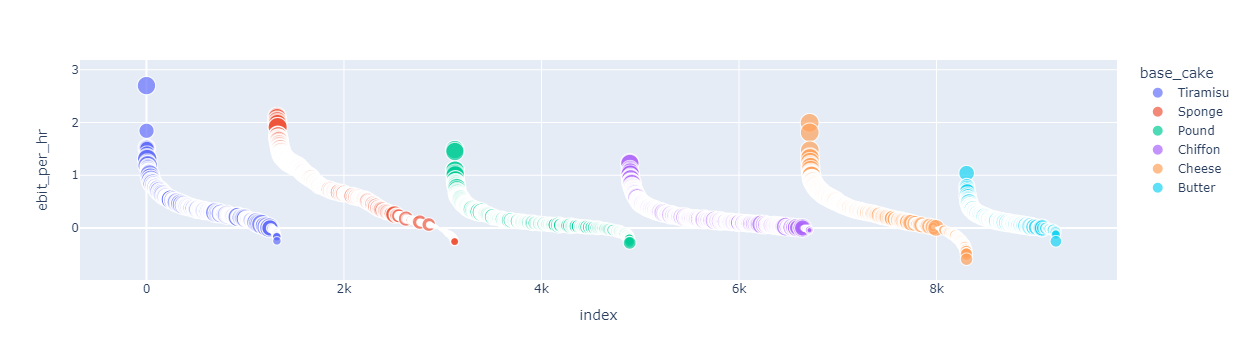

In [5]:
col = 'base_cake'
desc = 'primary_flavor'
val = 'Cheesecake'
x = 'ebit_per_hr'
y = 'ebit_per_hr'
size = 'kg_produced'
oee = oee.sort_values([col, x], ascending=False).reset_index(drop=True)
filt = oee#.loc[oee[desc] == val]
px.scatter(filt, 
           y=y, 
           x=oee.index,
           color=col,
          size=size)

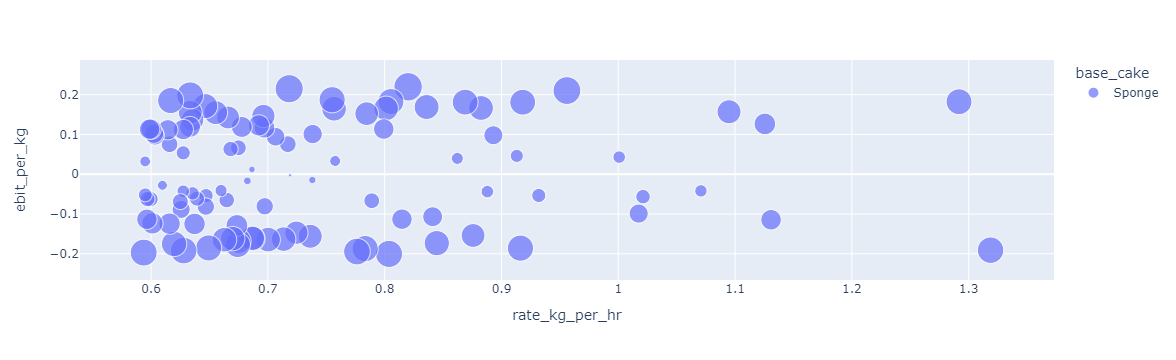

In [6]:
col = 'base_cake'
desc = 'primary_flavor'
val = 'Cheesecake'
x = 'rate_kg_per_hr'
y = 'ebit_per_kg'
oee = oee.sort_values([col, x], ascending=False).reset_index(drop=True)
filt = oee.loc[oee[desc] == val]
px.scatter(filt, 
           y=y, 
           x=x,
           color=col,
          size=size)

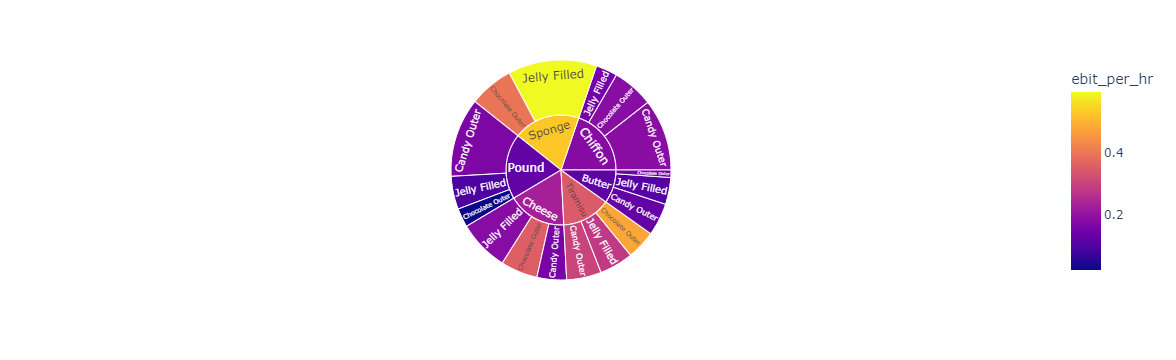

In [7]:
px.sunburst(oee, path=['base_cake', 'truffle_type'], color='ebit_per_hr')

In [8]:
moodsdf = pd.DataFrame()
target = 'ebit_per_hr'
for col in ['base_cake', 'truffle_type', 'primary_flavor', 'secondary_flavor',
       'color_group']:
    for truff in oee[col].unique():
        group = oee.loc[oee[col] == truff][target]
        pop = oee.loc[~(oee[col] == truff)][target]
        stat, p, m, table = scipy.stats.median_test(group, pop)
        median = np.median(group)
        mean = np.mean(group)
        size = len(group)
        welchp = scipy.stats.ttest_ind(group, pop, equal_var=False).pvalue
        moodsdf = pd.concat([moodsdf, 
                                  pd.DataFrame([col, truff, 
                                                stat, p, m, mean, median, size,
                                                welchp, table]).T])
moodsdf.columns = ['descriptor', 'group', 'pearsons_chi_square', 'p_value', 
                'grand_median', 'group_mean', 'group_median', 'size', 'welch p',
                'table']
moodsdf = moodsdf.loc[(moodsdf['welch p'] < 0.05) &
            (moodsdf['p_value'] < 0.05)].sort_values('group_median')

moodsdf = moodsdf.sort_values('group_median').reset_index(drop=True)
print(moodsdf.shape)

(80, 10)


In [9]:
moodsdf.loc[moodsdf['descriptor'] == 'truffle_type']

descriptor            group pearsons_chi_square      p_value  \
38  truffle_type      Candy Outer             82.3444  1.14322e-19   
39  truffle_type     Jelly Filled             4.72782    0.0296785   
45  truffle_type  Chocolate Outer             56.5048  5.60625e-14   

   grand_median group_mean group_median  size       welch p  \
38     0.171803   0.185359     0.145515  3352  1.65097e-104   
39     0.171803   0.318432     0.185311  3450   2.55493e-31   
45     0.171803   0.302639     0.220109  2408   8.05095e-10   

                           table  
38  [[1466, 3139], [1886, 2719]]  
39  [[1776, 2829], [1674, 2931]]  
45  [[1363, 3242], [1045, 3560]]

In [10]:
moodsdf['good_descriptor'] = moodsdf['group_median'] > moodsdf['grand_median']

In [11]:
# good results
moodsdf.loc[moodsdf['good_descriptor']].sort_values('pearsons_chi_square')[-5:].sort_values('group_median')

descriptor        group pearsons_chi_square       p_value  \
61         base_cake     Tiramisu             436.488   6.29338e-97   
72    primary_flavor     Horchata             110.399   8.01091e-26   
73    primary_flavor  Kettle Corn             106.577     5.511e-25   
75         base_cake       Sponge             467.701  1.01387e-103   
77  secondary_flavor    Tangerine             279.866   8.03086e-63   

   grand_median group_mean group_median  size       welch p  \
61     0.171803   0.348801     0.306147  1322   4.98946e-31   
72     0.171803   0.460761     0.510238   300   2.65054e-32   
73     0.171803   0.501702     0.511161   250   2.40663e-26   
75     0.171803   0.531622     0.529691  1800   8.8521e-171   
77     0.171803   0.616621     0.643669   300  2.88568e-107   

                          table  good_descriptor  
61  [[1013, 3592], [309, 4296]]             True  
72    [[240, 4365], [60, 4545]]             True  
73    [[206, 4399], [44, 4561]]             True  
75  [[1312, 3293], [488, 4117]]             True  
77     [[293, 4312], [7, 4598]]             True

In [12]:
# bad results
moodsdf.loc[~moodsdf['good_descriptor']].sort_values('pearsons_chi_square')[-5:].sort_values('group_median')

descriptor          group pearsons_chi_square       p_value  \
4   primary_flavor     Acai Berry             175.441   4.79559e-40   
10  primary_flavor           Sour             174.924   6.22157e-40   
13  primary_flavor  Caramel Cream             177.547   1.66385e-40   
19       base_cake          Pound             461.871  1.88235e-102   
21       base_cake         Butter             216.157   6.23157e-49   

   grand_median group_mean group_median  size       welch p  \
4      0.171803 -0.0484006   -0.0216689   178   2.41082e-85   
10     0.171803  0.0422168     0.040145   200  5.16073e-184   
13     0.171803  0.0713583    0.0499295   300  7.23512e-170   
19     0.171803     0.1278    0.0816101  1772  9.97833e-180   
21     0.171803   0.121889    0.0878631   905  6.80101e-141   

                          table  good_descriptor  
4      [[1, 4604], [177, 4428]]            False  
10     [[7, 4598], [193, 4412]]            False  
13    [[36, 4569], [264, 4341]]            False  
19  [[479, 4126], [1293, 3312]]            False  
21   [[242, 4363], [663, 3942]]            False

In [13]:
moodsdf_short = pd.concat([moodsdf.loc[moodsdf['good_descriptor']].sort_values('pearsons_chi_square')[-5:].sort_values('group_median'),
                           moodsdf.loc[~moodsdf['good_descriptor']].sort_values('pearsons_chi_square')[-5:].sort_values('group_median')])

In [14]:
moodsdf_short.reset_index(drop=True, inplace=True)

In [15]:
moodsdf_short.to_csv('moods_short.csv', index=False)

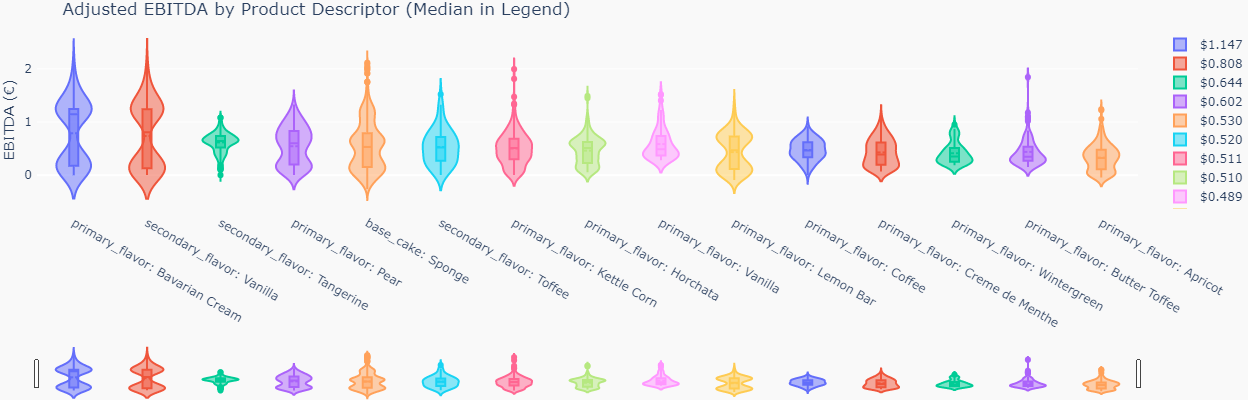

In [16]:
fig = go.Figure()
moodsdf = moodsdf.sort_values('group_median', ascending=False).reset_index(drop=True)
for index in range(15):
    x = oee.loc[(oee[moodsdf.iloc[index]['descriptor']] == \
        moodsdf.iloc[index]['group'])]['ebit_per_hr']
    y = moodsdf.iloc[index]['descriptor'] + ': ' + oee.loc[(oee[moodsdf\
        .iloc[index]['descriptor']] == moodsdf.iloc[index]['group'])]\
        [moodsdf.iloc[index]['descriptor']]
    name = '${:.3f}'.format(x.median())
    fig.add_trace(go.Violin(x=y,
                            y=x,
                            name=name,
                            box_visible=True,
                            meanline_visible=True))
fig.update_layout({
#                 "xaxis_range": [-0.5,4.5],
                "plot_bgcolor": "#F9F9F9",
                "paper_bgcolor": "#F9F9F9",
                "title": 'Adjusted EBITDA by Product Descriptor (Median in Legend)',
                "yaxis.title": "EBITDA (€)",
                "height": 400,
                "margin": dict(
                       l=0,
                       r=0,
                       b=0,
                       t=30,
                       pad=4
   ),
                })

fig.update_xaxes(rangeslider=dict(
            visible=True,
    autorange=True,
#     range=[-0.5,1.5],
#     range=['primary_flavor: Bavarian Cream', 'primary_flavor: Vanilla'],
        ))
fig.show()

# Jupyter Dashboard

In [20]:
colors = {'background': '#FFFFFF',
          'text': '#111111'}
style = {'height': 300}

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

df = pd.read_csv('oee_1000.csv')
moodsdf = pd.read_csv('moods_short.csv')

### FIGURES ###
def scatter(df, desc=None, val=None):
    x=df.index
    y='ebit_per_hr'
    if desc:
        df = df.loc[df[desc] == val]
        x = df.index
    fig = px.scatter(df, 
               y=y, 
               x=x,
            color='base_cake')
  
    fig.update_layout({
                    "plot_bgcolor": colors['background'],
                    "paper_bgcolor": colors['background'],
                    "title": 'EBIT per Hr by Base Cake',
                    "height": style['height'],
                    "margin": dict(
                           l=0,
                           r=0,
                           b=0,
                           t=30,
                           pad=4
       ),
                    })
    return fig


def sun(df, desc=None, val=None):
    path=['base_cake', 'truffle_type']
    if desc:
        df = df.loc[df[desc] == val]
        path=['base_cake', 'truffle_type', 'primary_flavor', 'secondary_flavor', 'color_group']
    fig = px.sunburst(df, path=path, color='ebit_per_hr')
    fig.update_layout({
                    "plot_bgcolor": colors['background'],
                    "paper_bgcolor": colors['background'],
                    
                    
                    "height": style['height'],
                    "margin": dict(
                           l=0,
                           r=0,
                           b=0,
                           t=30,
                           pad=4
       ),
                    })
    return fig
 
def violin(df, moodsdf, ascending=False):
    fig = go.Figure()
    moodsdf = moodsdf.sort_values('group_median', ascending=ascending).reset_index(drop=True)
    for index in range(5):
        x = df.loc[(df[moodsdf.iloc[index]['descriptor']] == \
            moodsdf.iloc[index]['group'])]['ebit_per_hr']
        y = moodsdf.iloc[index]['descriptor'] + ': ' + df.loc[(df[moodsdf\
            .iloc[index]['descriptor']] == moodsdf.iloc[index]['group'])]\
            [moodsdf.iloc[index]['descriptor']]
        name = '${:.2f}'.format(x.median())
        fig.add_trace(go.Violin(x=y,
                                y=x,
                                name=name,
                                box_visible=True,
                                meanline_visible=True))
    fig.update_layout({
                    "plot_bgcolor": colors['background'],
                    "paper_bgcolor": colors['background'],
                    "yaxis.title": "EBIT/HR",
                    "height": style['height']*1.4,
                    "margin": dict(
                           l=0,
                           r=0,
                           b=0,
                           t=30,
                           pad=4
       ),
                    })
    return fig

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

### LAYOUT ###
app.layout =  html.Div([
                html.H2(["Product Margin Analysis"
                    ],
                    style={'color': colors['text']}
                    ),
    html.Div([
    html.Div([
        html.H3("Controls", id='side'),
        html.Button('Reset', id='reset', n_clicks=0),
        html.P(),
        html.P("Run Moods Median Analysis For Products of:\n\n", id='msg-analysis'),
        html.Div([
            html.Button('High-Value', id='high', n_clicks=0),
            html.Button('Low-Value', id='low', n_clicks=0),
        ], className='row container-display'),
        html.P(),
        html.P("Select Product Descriptor in the Distributions Below"),
        html.P(),
        dcc.Graph(
            id='fig-3',
            figure=violin(df, moodsdf), # YOUR FIGURE HERE
            ),
        
    ], className='five columns'),
        
    html.Div([
        html.H3("Portfolio, All Products", id='main'),
                dcc.Graph(
                    id='fig-1',
                    figure=scatter(df), # YOUR FIGURE HERE
                    ),
                dcc.Graph(
                    id='fig-2',
                    figure=sun(df), # YOUR FIGURE HERE
                    ),
        ], className='seven columns'),
    ], className='row container-display'),
                html.P(id='test'),
                ],
                style={'backgroundColor': colors['background']}
                )

### MAIN CALLBACKS ###
@app.callback(
    [Output('fig-1', 'figure'),
     Output('fig-2', 'figure')],
    [Input('fig-3', 'clickData'),
     Input('reset', 'n_clicks'),
     Input('high', 'n_clicks'),
     Input('low', 'n_clicks'),])
def filter_data(data, reset, high, low):
    changed_id = [p['prop_id'] for p in callback_context.triggered][0]
    if 'reset' in changed_id:
        return scatter(df), sun(df)
    elif 'high' in changed_id:
        return scatter(df), sun(df)
    elif 'low' in changed_id:
        return scatter(df), sun(df)
    elif data:
        desc = pd.DataFrame(data['points'])['x'][0].split(": ")[0]
        val = pd.DataFrame(data['points'])['x'][0].split(": ")[1]
        return scatter(df, desc, val), sun(df, desc, val)
    else:
        return scatter(df), sun(df)
    
@app.callback(
    Output('main', 'children'),
    [Input('fig-3', 'clickData'),
     Input('reset', 'n_clicks'),
     Input('high', 'n_clicks'),
     Input('low', 'n_clicks'),])
def filter_data(data, reset, high, low):
    changed_id = [p['prop_id'] for p in callback_context.triggered][0]
    if ('reset' in changed_id) or ('low' in changed_id) or ('high' in changed_id):
        return "Portfolio, All Products"
    elif data:
        desc = pd.DataFrame(data['points'])['x'][0].split(": ")[0]
        val = pd.DataFrame(data['points'])['x'][0].split(": ")[1]
        return "Portfolio from Selection: {}".format(val)
    else:
        return "Portfolio, All Products"

### SIDE CALLBACKS ###
@app.callback(
    Output('fig-3', 'figure'),
    [Input('high', 'n_clicks'),
     Input('low', 'n_clicks'),])
def filter_data(high, low):
    changed_id = [p['prop_id'] for p in callback_context.triggered][0]
    if 'high' in changed_id:
        return violin(df, moodsdf, ascending=False)
    elif 'low' in changed_id:
        return violin(df, moodsdf, ascending=True)
    else:
        return violin(df, moodsdf, ascending=False)
    
app.run_server(mode='jupyterlab')

In [24]:
import plotly

In [26]:
plotly.__version__

'5.2.2'